<a href="https://colab.research.google.com/github/cjohnsoncruz/neural_network_correlation_shuffle/blob/main/pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [1]:
### Import all the necessary libraries
import scipy.io
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor


from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu device


In [2]:
#CREATE A FUNCTION TAHT PERFORMS SHARC, compare to swap
def do_sharc_shuffle():
      #each raster is equivalent to a collection of blocks of activity. Each block of activity is defined by the time at which it begins, its duration, and the neuron which is active.  
  activity_blocks = list()
  block_info = {'begin':[], 'duration':[], 'ID':[]}
  pass

def do_swap_shuffle():
    pass

def create_empty_corr_matrix(raster):
        #INPUT: raster (neuron x frame input)
  og_corrs = np.corrcoef(raster)
  new_corrs = np.zeros(og_corrs.shape)
  return new_corrs
    #activity blocks must contain 1) a begin time 2) a duration and 3) neuron ID
    #each dict can contain all 3 
    #SHARC is an iterative method for generating surrogate datasets.
    
    #SHARC nonrandomly shuffles blocks of activity within a raster to generate a new (surrogate) raster in which the pairwise correlations between neurons match a target correlation matrix

In [3]:
# create class for framewise activity 
class raster_dataset(Dataset):
  """ neuron dataset"""
  def __init__(self, mat_filename, transform = None):
    mat = scipy.io.loadmat(mat_filename);
    self.spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 
    self.transform = transform
    self.shape = self.spikes.shape
  def __len__(self):
    return self.spikes.shape[1]

  def __getitem__(self, index):
    sample = self.spikes[:,index]
    return sample 

  def get_slice(self, index):
    return self.spikes[:, index]

  def get_sub_slice(self, row_index, col_index):
    return self.spikes[row_index, col_index]

#create class to store information on feature vector
class feature_vec(Dataset):

  def __init__(self, labels):
    self.labels = torch.from_numpy(labels) #transform label vector into tensor

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, indx):
    return self.labels[indx]


def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)

class label_raster_dataset(Dataset):
  """ combined label raster dataset""" 
  def __init__(self, raster, labels):
    self.raster = raster.spikes
    self.labels = labels.labels 
    self.num_neurons = self.raster.shape[0]
  
  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, indx):
    raster = self.raster[:,indx]
    rep = raster.shape[0] #number of times to repeat the labels to match size of raster

    label = torch.from_numpy(np.tile(self.labels[0,indx], (rep,1)))
    return raster, label #outputs tuple of tensors



In [4]:
## NETWORK TRAINING AND PLOTTING RELATED FUNCTIONS
def single_epoch_train(x_train, y_train, model_train, predicted, losses, loss_function, optimizer, s):
    optimizer.zero_grad() #zero gradient before calculating for each step
    output = model_train(x_train) 
    #calculate loss
    loss = loss_function(output, y_train.float())
    #accuracy
    predicted.append(output[0].item())
    #important backprop
    loss.backward()
    optimizer.step()
    losses.append(loss)
    #accur.append(acc)
    if s % 100 == 0:
      print('train ex' + str(s) + str(loss))
    return losses, predicted
    #print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

def generate_train_index(full_len, train_len, train_type):
  if train_type == 'range':
      train_range = np.arange(1,train_len+1) #to get the range in the right dimensions for iteration
  elif train_type == 'rand':
      rand_nums = np.random.randint(0,full_len, (train_len,1))
      train_range = rand_nums
      #no, you want to pick N random nubmers from range -:full_len
  elif train_type == 'bool_range':
      bool_rand_length = np.random.randint(2, size=train_len).astype(bool) #2 exlucsive, so just 1 or 0
      train_range = np.arange(1,train_len+1)[bool_rand_length]
  return train_range

#build neural network
class myNet(nn.Module):
    def __init__(self, num_neurons): #input in the number of neurons you want to use 
        super(myNet, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(num_neurons, 1000) #num neurons IN, 1000 OUT
        self.fc2 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        x = self.relu(x)#then apply relu
        x = self.fc2(x) #pass 2nd layer/output layer input (1000 ->1), 
        x = self.sigmoid(x) #then apply sigmoid for output
        return x

#temp placeholder function
def plot_performance(loss, predict):
  #set training range
  fig, ax = plt.subplots(2,1, figsize = (12,7))
  ax[0].plot(loss)
  ax[0].set_title('Model Training Loss')
  ax[1].plot(predict);
  ax[1].set_title('Output Layer Output ');

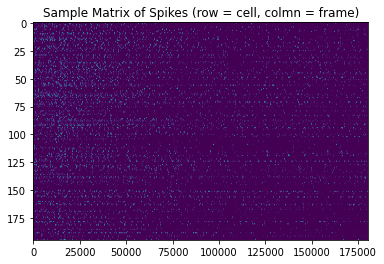

In [5]:
filename = '/content/drive/MyDrive/sampleMat.mat'
raster = raster_dataset(filename)

plt.figure();#figsize = (4,4))
plt.imshow(raster.spikes, aspect = 'auto');
plt.title('Sample Matrix of Spikes (row = cell, colmn = frame)');

In [6]:
#create random dataset for testing function of NN
rand_labels = make_rand_labels(len(raster))
rand_labels = feature_vec(rand_labels)
rand_dataset = label_raster_dataset(raster,rand_labels)
#create NN network based on size of random raster (in turn based on real dataset)
rand_model = myNet(rand_dataset.num_neurons)
### Define your loss function (training criterion)
### Choose your optimizer
optimizer = optim.Adam(rand_model.parameters(), lr=0.05) #0.05 is learning rate from frost et al
loss_function = nn.BCELoss()
# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', rand_model)

Optimizer is : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
loss function is  BCELoss()
Device is cpu
model is myNet(
  (fc1): Linear(in_features=195, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


Run a model on random labels and eval performance

In [7]:
predictions_dict = dict()
losses_dict = dict()
predictions_dict['random'] = []
losses_dict['random'] = []

#set training range
train_range = generate_train_index(raster.shape[0], 1000, 'rand')
train_range.shape

(1000, 1)

train ex[0]tensor(0.7710, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.7395, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.7265, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.7658, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.2743, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(1.9780, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(4.0494, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.6063, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.6800, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.7853, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.6542, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.5894, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.6529, grad_fn=<BinaryCrossEntropyBackward0>)


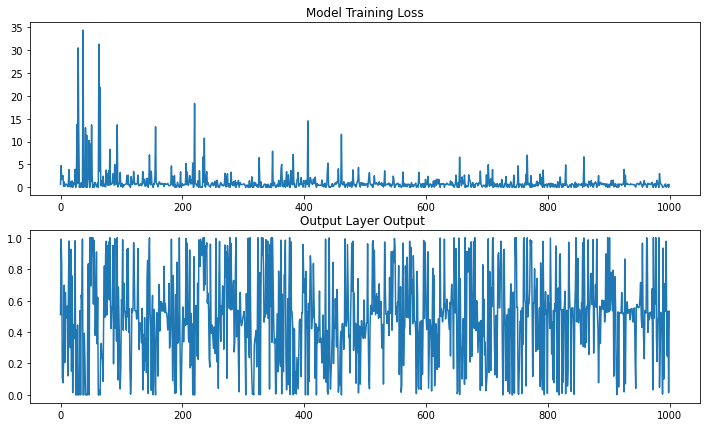

In [8]:

rand_model.train() # sets the parameters to be trainable

for s in (train_range): 
  optimizer.zero_grad() #zero gradient before calculating for each step
  x_train = torch.t((raster.spikes[:,s]))  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = rand_labels.labels[:,s]
  single_epoch_train(x_train, y_train, rand_model, predictions_dict['random'], losses_dict['random'], loss_function, optimizer, s)

plot_performance(losses_dict['random'], predictions_dict['random'])

As expected, creating random labels leads to the neural network not converging to a local minima for the cost function

Now create a more structured dataset, where activity depends on the status of the boolean label. Can this network learn it?

new raster shape is(50, 180310)


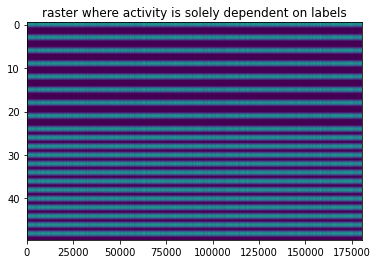

In [9]:
label_mask = rand_labels.labels[0]== 1
label_mask = label_mask.numpy() #create numpy boolean mask for indexing
d_raster_size = 50
#create raster that is dependent on random labels
dependent_raster = np.zeros((d_raster_size,len(label_mask)))
dependent_raster[0:round(d_raster_size/2):3, label_mask] = 1
dependent_raster[round(d_raster_size/2)+1::2, label_mask] = 1
# plot new raster for viz
print('new raster shape is' + str(dependent_raster.shape))
plt.imshow(dependent_raster, aspect = 'auto');
plt.title('raster where activity is solely dependent on labels');

In [10]:
#create dependent_raster based model
depend_model = myNet(d_raster_size) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.SGD(depend_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', rand_model)


Optimizer is : SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss function is  BCELoss()
Device is cpu
model is myNet(
  (fc1): Linear(in_features=195, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [11]:
#SET STORAGE AND METAPARAMETERS
raster
predictions_dict['depend'] = []
losses_dict['depend']  = []
 #set training range
train_length = 1000
train_index = generate_train_index(raster.shape[0], train_length, 'rand')


train ex[0]tensor(0.2312, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.0129, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.0027, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.0130, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.0094, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.0012, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.0074, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.0064, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.0007, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[0]tensor(0.0057, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[100]tensor(0.0006, grad_fn=<BinaryCrossEntropyBackward0>)


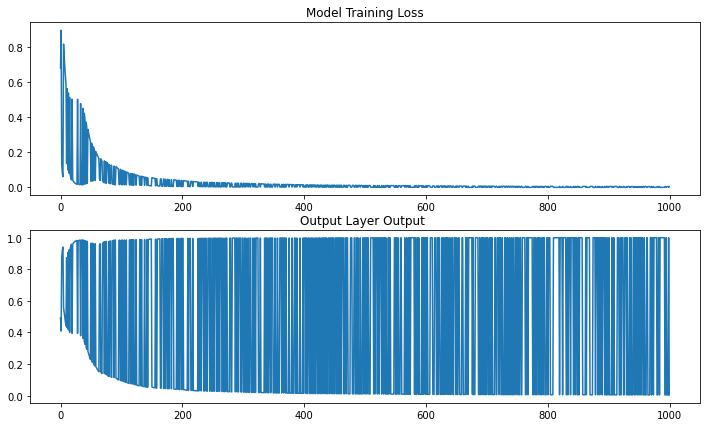

In [12]:
#TRAIN MODEL AND PLOT PERFORMANCE
depend_model.train()

for s in (train_index): 
  x_train = torch.t(torch.from_numpy(dependent_raster[:,s]))  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = rand_labels.labels[:,s]
  single_epoch_train(x_train, y_train, depend_model, predictions_dict['depend'], losses_dict['depend'], loss_function, optimizer, s)

plot_performance(losses_dict['depend'], predictions_dict['depend'])

As expected, a smaller neural network is able to learn the case where "neuron" activity is purely a function of the binary label vector.



Now, lets use **real** data to predict **real** class labels, using a sample dataset

In [13]:
#import real (sample) label vector 
real_label_filename = '/content/drive/MyDrive/7-6_1V_labels.mat'
label_mat = scipy.io.loadmat(real_label_filename);
label_mat
real_labels_array = label_mat['pad_labels_7_6']
real_labels_array
real_labels_object = feature_vec(real_labels_array)
labels_obj_isRS = feature_vec(real_labels_array>8)
labels_obj_isRS.labels.shape

torch.Size([1, 180310])

The input label vector is a categorical vector, where integers from 0-15 represent a behavioral state for the mouse during the task. This span actually represents two duplicate lists of behaviors: behaviors encoded by 1-8 are identical to the ones encoded by 9-15. Behaviors are categorized by whether they occur in the Rule 1 period, or Rule 2 period. Rule 1 behaviors are below 9, and Rule 2 behaviors are above 9.
For this first attempt at classification, I will one-hot encode whether a given frame is in the Rule 1 period (IA) or Rule 2 period (RS)

In [17]:
#set up test train splits
predictions_dict['isRS'] = []
losses_dict['isRS']  = []

#set training range
train_index = generate_train_index(raster.shape[1], 5000, 'rand')
#instantiate model and declare parameters
#create dependent_raster based model
isRS_model = myNet(raster.shape[0]) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.SGD(isRS_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', rand_model)


Optimizer is : SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss function is  BCELoss()
Device is cpu
model is myNet(
  (fc1): Linear(in_features=195, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


Text(0.5, 1.0, 'Train Set Feature Vector')

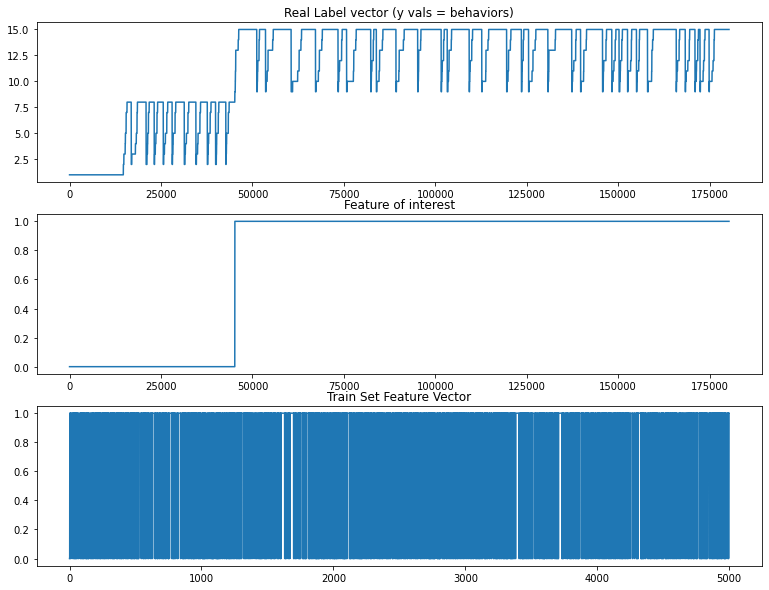

In [18]:
fig, ax = plt.subplots(3,1, figsize = (13,10))
ax[0].plot(real_labels_array[0,:]);
ax[0].set_title('Real Label vector (y vals = behaviors)');

ax[1].plot(labels_obj_isRS.labels[0,:]);
ax[1].set_title('Feature of interest- IN IA');

ax[2].plot(labels_obj_isRS.labels[0,train_index])
ax[2].set_title('Train Set Feature Vector')

train ex0tensor(0.7162, grad_fn=<BinaryCrossEntropyBackward0>)
train ex100tensor(0.3382, grad_fn=<BinaryCrossEntropyBackward0>)
train ex200tensor(0.2701, grad_fn=<BinaryCrossEntropyBackward0>)
train ex300tensor(0.2702, grad_fn=<BinaryCrossEntropyBackward0>)
train ex400tensor(0.2851, grad_fn=<BinaryCrossEntropyBackward0>)
train ex500tensor(0.1744, grad_fn=<BinaryCrossEntropyBackward0>)
train ex600tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
train ex700tensor(0.7954, grad_fn=<BinaryCrossEntropyBackward0>)
train ex800tensor(0.1460, grad_fn=<BinaryCrossEntropyBackward0>)
train ex900tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1000tensor(0.5389, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1100tensor(0.4730, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1200tensor(1.6840, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1300tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1400tensor(0.0865, grad_fn=<BinaryCrossEntropyBackward0>)
train ex1500tensor(0.3

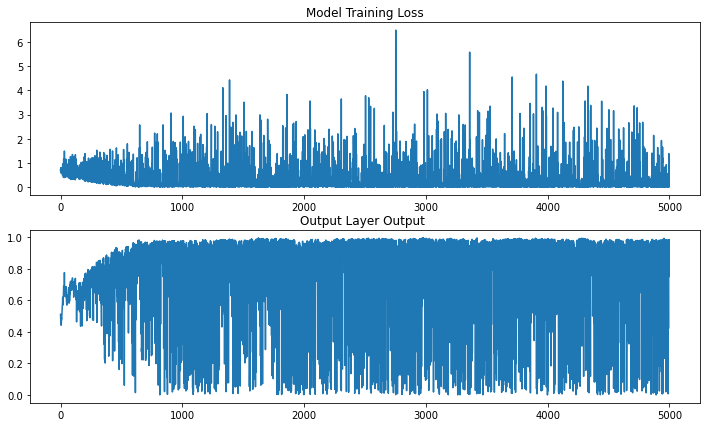

In [19]:
#TRAIN MODEL AND PLOT PERFORMANCE
isRS_model.train()

for index, s in enumerate(train_index): 
  x_train = torch.t(raster.spikes[:,s])  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = labels_obj_isRS.labels[:,s]
  single_epoch_train(x_train, y_train, isRS_model, predictions_dict['isRS'], losses_dict['isRS'], loss_function, optimizer, index)

plot_performance(losses_dict['isRS'], predictions_dict['isRS'])

With 5000 training examples, a neural net architecture that was able to grasp the simple previous associations is unable to grasp the true information underlying what rule is present when, using single frames and SGD.

It's possible that information about status is on longer timescales than frames or 1/20th of seconds. Could try changing optimization function (to including momentum) or taking averages to slightly increase information available to network.